<a href="https://colab.research.google.com/github/201ssc/python_test1/blob/main/4_8_%EC%A0%84%EB%AC%B8%EA%B0%80_%EC%A7%80%EC%8B%9D_%ED%99%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mglearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import matplotlib

from sklearn.model_selection import train_test_split

from sklearn.datasets import load_breast_cancer
from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.datasets import load_digits

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import QuantileTransformer, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set(font_scale=3)
sns.set(rc = {'figure.figsize':(12,8)})

from pandas.core.common import random_state

In [3]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import os
import sys
if 'google.colab' in sys.modules and not os.path.isdir('mglearn'):
    # 사이킷런 최신 버전을 설치합니다.
    !pip install -q --upgrade scikit-learn
    # mglearn을 다운받고 압축을 풉니다.
    !wget -q -O mglearn.tar.gz https://bit.ly/mglearn-tar-gz
    !tar -xzf mglearn.tar.gz
    !wget -q -O data.tar.gz https://bit.ly/data-tar-gz
    !tar -xzf data.tar.gz
    # 나눔 폰트를 설치합니다.
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    fm._rebuild()

In [4]:
import sklearn
from preamble import *
import matplotlib

# 나눔 폰트를 사용합니다.
matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

# 4.8 특성 공학은 전문지식을 사용할 수 있는 중요한 영역이다.
많은 경우 머신러닝의 목적은 전문가의 설계에 의존하지 않는 것이지만, 그렇다고 전문 지식을 무시된다는 의미가 아니다. 왜냐하면 초기 데이터에 유용한 특성을 선택하거나(특성을 추가로 넣거나) 하여 성능을 좋게 할 수 있기 때문이다.

\
다음은 앤디가 집 앞 자전거 대여소에 데이터를 받아와, 자신이 언제 자전거를 빌릴 수 있는지 예측하는 상황이다.
[자전거 대여 데이터](https://www.citibikenyc.com/system-data)는 익명으로 공개되어있다.
기간은 2015년 8월 으로 하겠다.

In [5]:
citibike = mglearn.datasets.load_citibike()
print("city bike data: \n", citibike.head())

city bike data: 
 starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


Text(0, 0.5, '대여 횟수')

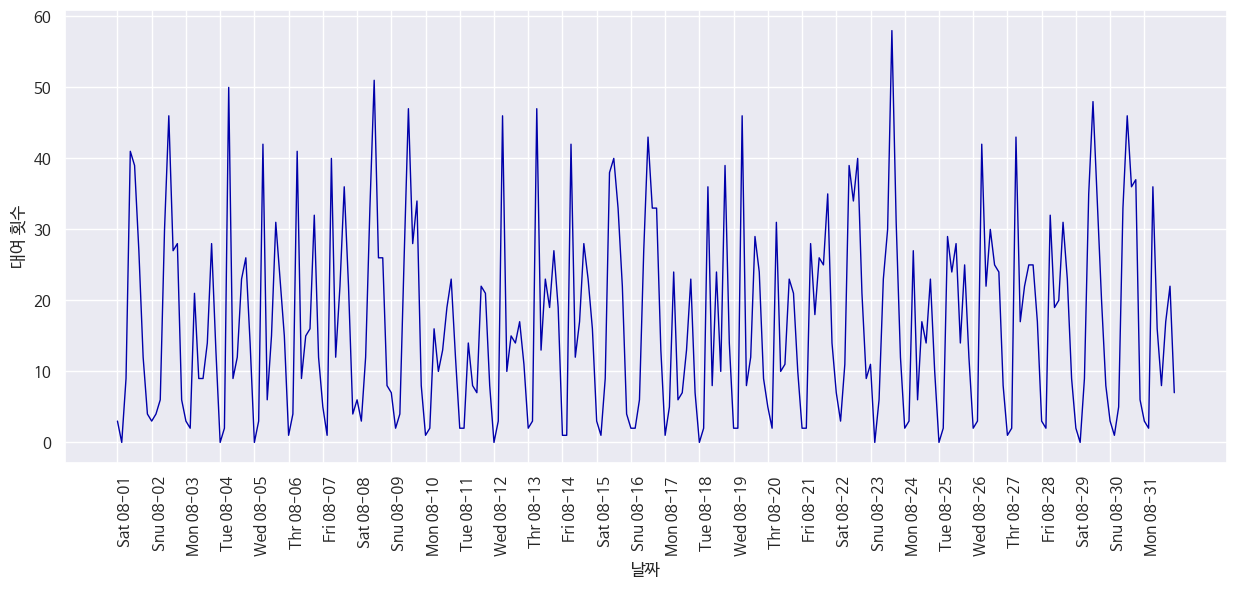

In [6]:
# 한 달 동안에 대여 횟수를 그래프로 나타낸다.
plt.figure(figsize=(15, 6))
xticks = pd.date_range(start= citibike.index.min(), end=citibike.index.max(), freq='D')
week = ['Snu','Mon','Tue','Wed','Thr','Fri','Sat']
xticks_name = [week[int(w)] + d for w, d in zip(xticks.strftime("%w"), xticks.strftime(" %m-%d"))]
plt.xticks(xticks, xticks_name, rotation=90, ha='left')
plt.plot(citibike, linewidth=1)
plt.xlabel("날짜")
plt.ylabel("대여 횟수")

시간 데이터가 낮과 밤에 차이를 보이는 것처럼, 날짜에서도 주말과 평일에 차이를 확인할 수 있다.

In [7]:
# 타깃 값 추출 (대여 횟수)
y = citibike.values
# POSIX 시간을 10**9로 나누어 변환  >> 1970 1.1 00:00:00 이후 경과시간을 초로 나타냄
X = citibike.index.astype('int64').values.reshape(-1, 1) // 10**9 


In [8]:
# 처음 184개 데이터 포인트를 훈련 세트로 사용하고 나머지는 테스트 세트로 사용합니다
n_train = 184

# 주어진 특성을 사용하여 평가하고 그래프를 만듭니다
def eval_on_features(features, target, regressor):
    # 훈련 세트와 테스트 세트로 나눕니다
    X_train, X_test = features[:n_train], features[n_train:]
    # 타깃값도 나눕니다
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("테스트 세트 R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks_name, rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="훈련")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="테스트")
    plt.plot(range(n_train), y_pred_train, '--', label="훈련 예측")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="테스트 예측")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("날짜")
    plt.ylabel("대여횟수")

테스트 세트 R^2: -0.04


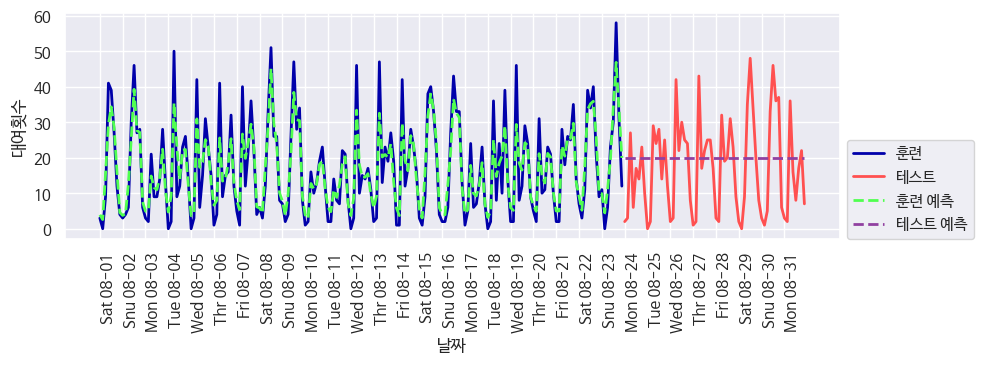

In [9]:
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor)

훈련 예측은 잘된다. 그런데 테스트셋에 대해서 한 가지 값으로만 예측했다. 
문제는 랜덤 포레스트와 특성 사이의 조합에있다. 테스트 셋에 있는 POSIX 시간 특성의 값은 훈련 셋에 있는 특성 값의 범위 밖에 있다. 트리 모델인 랜덤 포레스트는 훈련세트에 있는 특성의 법위 밖으로 외삽 할 수 있는 능력이 없다. 결국 모델은 테스트셋과 가장 가까운 마지막 훈련셋 데이터의 타깃값을 예측으로 사용한다.


\
이에 전문가 지식이 필요하다.시간과 요일 두요소가 중요한것으로 보인다. 그럼 이 두 특성을 추가한다.

테스트 세트 R^2: 0.60


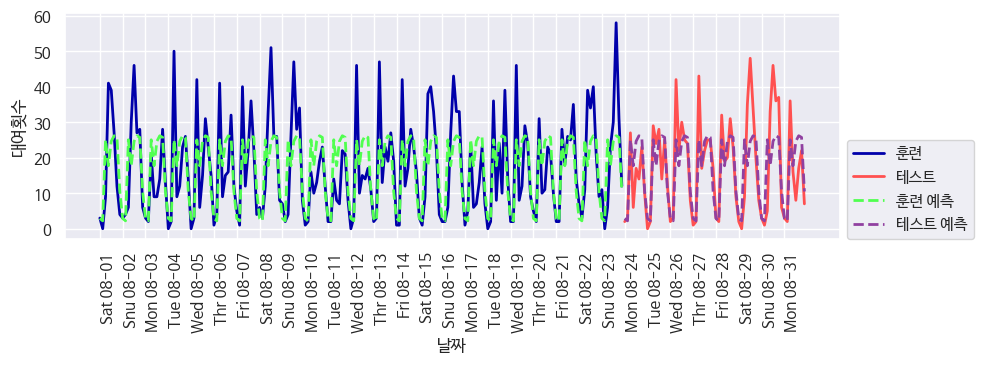

In [10]:
# 시간 추가
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor)

테스트 세트 R^2: 0.84


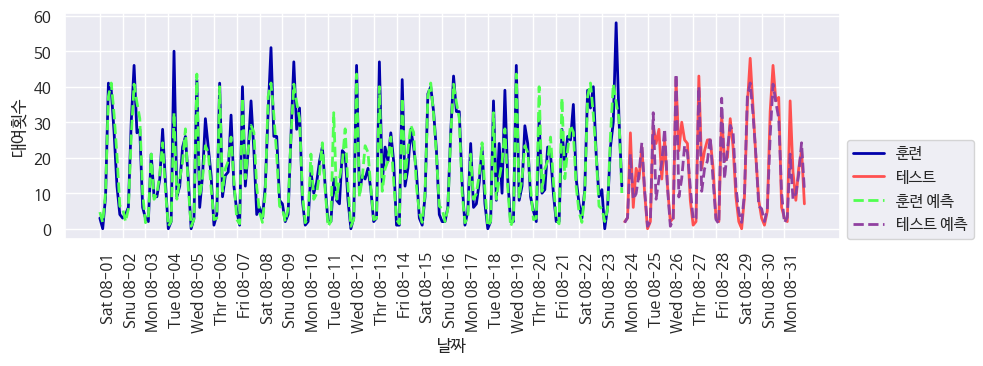

In [11]:
# 요일 추가
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor)

0.84 까지 올라갔다. 사실 데이터가 작고 복잡하지 않은 모델이라서 랜덤이 필요하지 않다. 간단한 모델 선형회귀를 사용해보자.

테스트 세트 R^2: 0.13


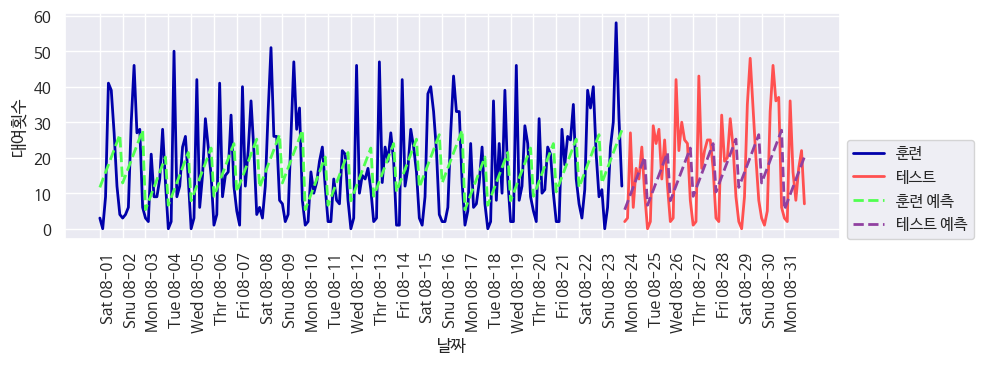

In [13]:
from sklearn.linear_model import LinearRegression
eval_on_features(X_hour_week, y, LinearRegression())

성능이 나쁘고 주기 패턴도 이상하다. 이유는 요일과 시간이 정수로 인코딩되어 연속형 변수로 해석되기 때문이다. 선형 모델은 시간을 성형 함수로만 학습할 수 있어서, 하루에서 시간이 흐를 수록 대여 수가 늘어나게 학습되었다. 하지만 실제 패턴은 이보다 복잡하다. 온핫인코더를 사용해 정수형을 범주형 변수로 해석하도록 하자

테스트 세트 R^2: 0.62


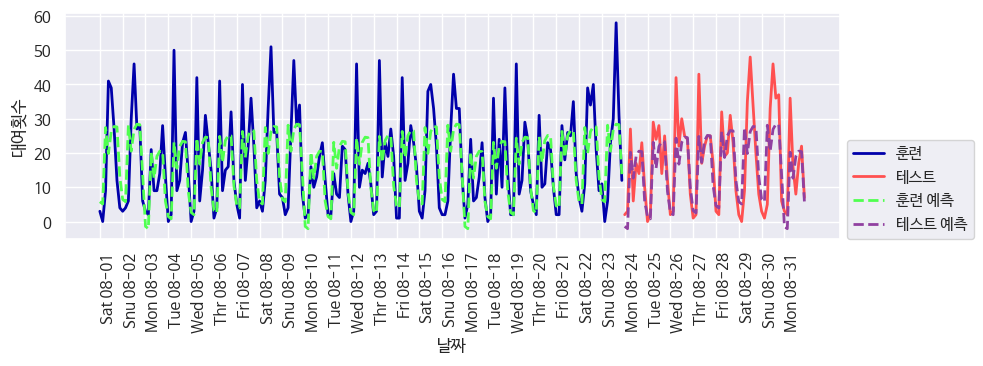

In [16]:
enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge())

In [18]:
X_hour_week_onehot.shape

(248, 15)

In [21]:
citibike.shape

(248,)

요일마다, 시간마다 하나의 계수를 학습함. 상호작용 특성을 사용하면 요일의 조합별 계수를 학습할 수 있다

테스트 세트 R^2: 0.85


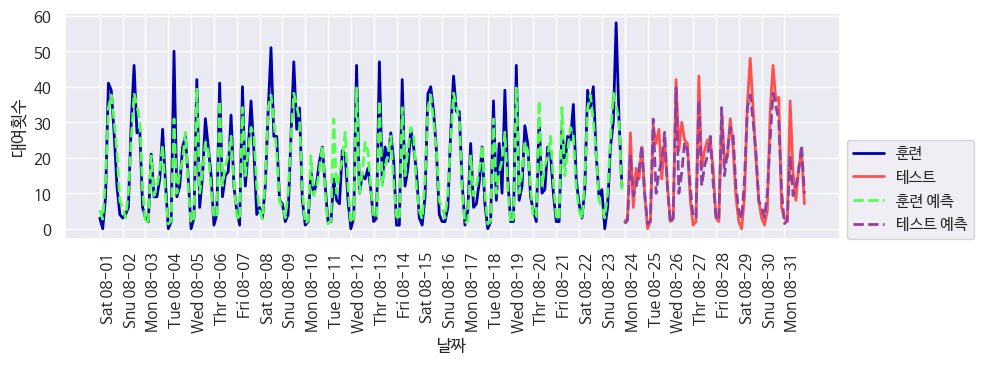

In [22]:
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr)

특성 변환을 통해 모델의 성능이 랜덤포레스트와 거의 비슷해 졌다. 이 모델의 큰 장점은 무엇이 학습되었는지가 명확하다는 것이다. 바로 각 날짜와 시간에 대해 하나의 계수를 학습했다. 랜덤 포레스트와는 달리 이 모델이 학습한 계수를 그래프로 나타낼 수 있다.

In [23]:
# 시간과 요일 특성의 이름을 짓는다.
hour = ["%02d:00" % i for i in range(0, 24, 3)]
day = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
features = day + hour

In [25]:
# 모든 상호작용 특성에 이름을 달아 준다.
features_poly = poly_transformer.get_feature_names_out(features)
features_nonzero = np.array(features_poly)[lr.coef_ != 0]
coef_nonzero = lr.coef_[lr.coef_ !=0]

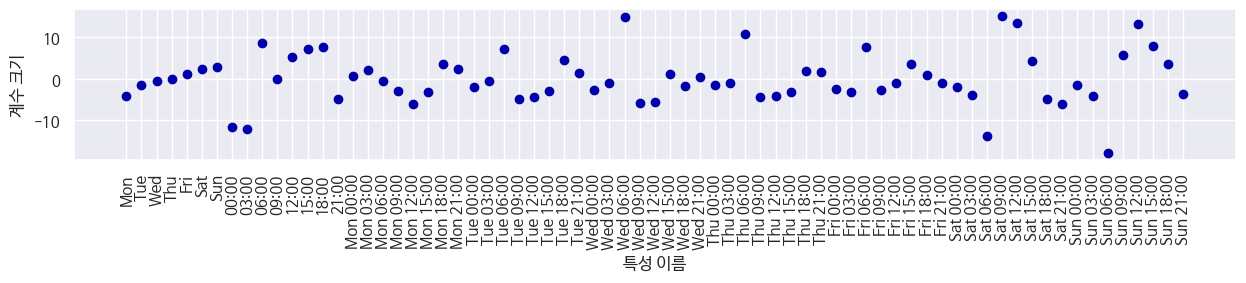

In [26]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')
plt.xticks(np.arange(len(coef_nonzero)), features_nonzero, rotation=90)
plt.xlabel("특성 이름")
plt.ylabel("계수 크기")
plt.show() # 책에는 없음

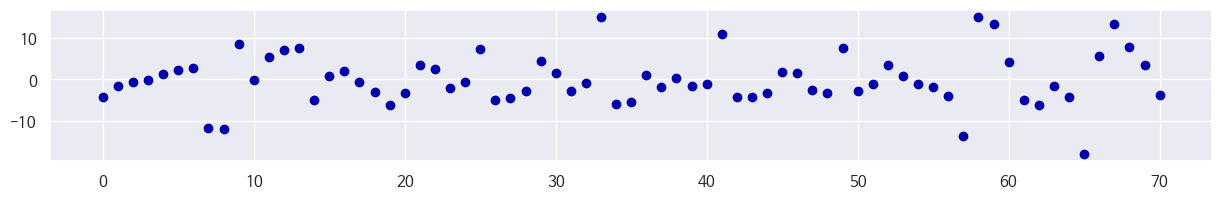

In [28]:
plt.figure(figsize=(15, 2))
plt.plot(coef_nonzero, 'o')

In [30]:
coef_nonzero

array([ -4.167,  -1.596,  -0.524,  -0.06 ,   1.226,   2.264,   2.858,
       -11.694, -12.111,   8.613,  -0.08 ,   5.369,   7.243,   7.637,
        -4.977,   0.718,   2.031,  -0.512,  -2.992,  -6.079,  -3.234,
         3.47 ,   2.431,  -1.96 ,  -0.647,   7.309,  -4.921,  -4.508,
        -2.913,   4.542,   1.502,  -2.764,  -0.951,  15.006,  -5.975,
        -5.561,   1.033,  -1.762,   0.449,  -1.612,  -1.049,  10.908,
        -4.323,  -4.159,  -3.315,   1.89 ,   1.601,  -2.576,  -3.263,
         7.693,  -2.787,  -1.124,   3.471,   0.926,  -1.114,  -1.912,
        -3.978, -13.758,  15.197,  13.438,   4.338,  -4.976,  -6.085,
        -1.588,  -4.254, -18.033,   5.721,  13.362,   7.863,   3.548,
        -3.761])

## 4.9 요약 및 정리
이번 장에서 여러 종류의 데이터 타입(특히 범주형 변수)을 다루는 법을 배웠다. 예를 들어 원핫인코닝 범주형 변수처럼 머신러닝 알고리즘에 적합ㅎ나 방식으로 데이터를 표현하는 것이 아주 중요함을 설명했다. 그리고 새로운 특성을 만드는 것과 데이터에서 특성을 유도하기 위해 전무가의 지식을 활용하는 것에 대해 다뤘다. 특히 선형모델은 구간 분할이나 다항식과 상호작용 특성을 새로 추가해 큰 이득을 볼 수 있다. 반면, 랜덤 포레스트나 svm 같은 비선형 모델은 특성을 늘리지 않고서도 복잡한 문제를 학습할 수 있다. 실제로 어떤 특성을 사용하나. 그리고 특성과 모델의 궁합이 중요함을 알 수 있었다.

\
다음 장은 머신러닝 모델의 성능을 평가하고, 올바른 매개변수를 선택하는 방법을 다루도록 하겠다.